# Wikipedia

In [1]:
#Imports
from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
from fa2 import ForceAtlas2
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime
from ipywidgets import *
import ipywidgets as widgets
import time
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import seaborn as sns
import gif


#Init stopwords
stop_words = set(stopwords.words('english'))

## Introduction: What we wish to accomplish

The second part of the analysis is related to data from Wikipedia. Specifically, we investigate the wikipedia pages written on the decades (E.g <a href="https://en.wikipedia.org/wiki/1990s"> 1990s </a>). <br>

<u> Two main analyses are conducted on the Wikipedia data </u>:
* Sentiment analysis
* Worldclouds

The purpose of these analyses is to compare them with equivalent analyses from the Hollywood network and investigate whether movie descriptions from Hollywood can be used as a <b> sign of the times </b>, that is, can movie descriptions be used to infer something about the concurrent time of which they are produced?

### Sentiment Analysis

<b> What are we interested in? </b>

In the sentiment analysis of the wikipedia pages, we want to examine the sentiment of the different decades ranging from the 1910s to the 2010s. Are there any decades that are significantly happier or sadder than others? <br>

The wikipedia data is obtained by scraping the wikipedia pages. We apply a series of regular expressions to obtain the relevant text and utilize natural language processing to stem the words and so on.

<b> Apply the tool </b>

We start by defining functions used to scrape the wikipedia pages

In [60]:
#The content of the characters' wiki-pages is extracted using the wikipedia API
baseurl = 'https://en.wikipedia.org/w/api.php?'
action = 'action=query'
title = 'titles='
content = 'prop=revisions&rvprop=content'
dataformat = 'format=json'

def look_up_decade(year: int)-> str:
    '''
    This function takes a particular year as an argument and returns
    the wiki pages corresponding to the decade to which the year belongs
    '''
    decade_start=int(year/10)*10
    query = '%s%s&%s&%s&%s' % (baseurl,action,f'titles={decade_start}s',content,dataformat)
    res = json.loads(urllib.request.urlopen(query).read().decode('utf-8'))
    pages = res.get('query').get('pages')
    if not pages:
        raise Exception('No pages found')
    data = []
    for page in pages.keys():
        try:
            data.append(res['query']['pages'][page]['revisions'][0]['*'])
        except:
            print(f"Failed on pages{page}")
    return data

def process_data(d:list, limit=3)->list:
    '''
    This function takes in a list of wikipedia str pages and returns
    the relevant informations (e.g removing links, redirects and other special characters)
    '''
    data_string = ''
    temp_str = ''
    
    i=0
    for x in d:
        if i>=limit:
            break
        # Remove special chars and data in links
        temp_str=re.sub("[\{\<.*?[\}\>]", "", x)
        # Remove links
        temp_str=re.sub('url=.\S*','',temp_str)
        # Weird chars
        temp_str=re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str)
        # Remaning links
        temp_str=re.sub('http.\S*','',re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str))
        # Remaning links
        temp_str=re.sub('redirect.\S*','',temp_str)
        data_string += temp_str
        i+=1
    return data_string    

We identify the decades we wish to analyse

In [62]:
decades = np.arange(1910, 2020, 10)
print(decades)

[1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010]


We extract the wiki pages in a list of lists where the outer lists are the decades and the inner lists are the tokenized words of that decade

In [63]:
wiki_decades = [tokenize(process_data(look_up_decade(d))) for d in decades]

In [67]:
print("Example of {0}s".format(decades[0]))
print()
print("{0} ...".format(wiki_decades[0][20:40]))

Example of 1910s

['causes', 'deaths', 'nearly', 'people', 'attracts', 'global', 'historical', 'attention', 'title', 'bar', 'events', 'part', 'world', 'war', 'french', 'army', 'lookout', 'observation', 'post', 'russian'] ...


A few interesting words such as "deaths" and "army" turn up. We keep in mind that the 1910s was the decade of WW1

We read in the sentiment definition of the words

In [144]:
path = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'

#Read data
sentiment = pd.read_csv(path, skiprows = 2, sep = '\t')

#Remove "neutral words"
sentiment = sentiment[(sentiment['happiness_average']>6) | (sentiment['happiness_average']<4)]

In [145]:
sentiment.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [146]:
#Dictionary to look up average hapiness for a given word
sentiment_lookup = sentiment[['word', 'happiness_average']].set_index('word').to_dict()['happiness_average']
print("Example:")
print(list(sentiment_lookup.items())[:5])

Example:
[('laughter', 8.5), ('happiness', 8.44), ('love', 8.42), ('happy', 8.3), ('laughed', 8.26)]


In [147]:
sentiment_decades = {}
for i, d in enumerate(decades):
    sentiment_decades[d] = list(map(sentiment_lookup.get, wiki_decades[i]))
    sentiment_decades[d] = [x for x in sentiment_decades[d] if x != None] #Remove words with no sentiment

In [148]:
print("Example")
print("1910", sentiment_decades[1910][:10], "...")

Example
1910 [6.28, 3.48, 1.64, 6.16, 6.26, 6.52, 1.8, 6.29, 2.42, 7.58] ...


We can now plot the sentiment distribution for each decade as well as the development in sentiment over the decades

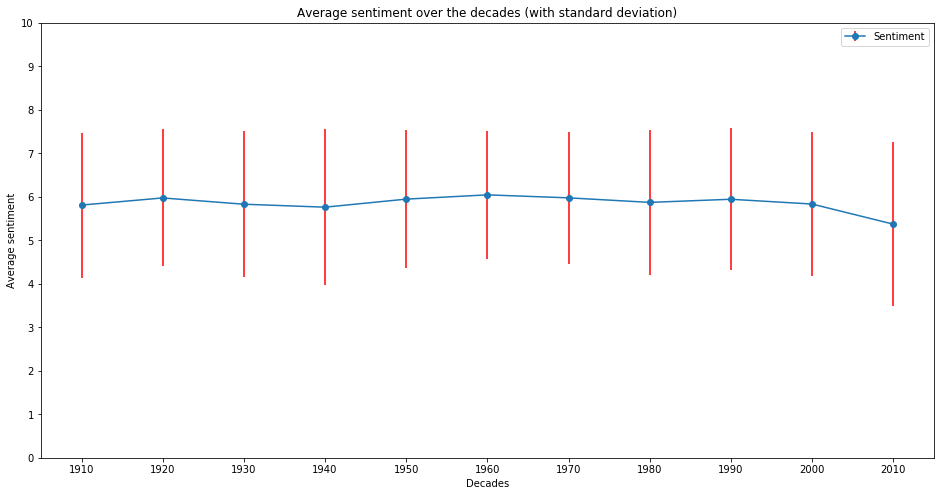

In [167]:
x = decades
y = [np.mean(sentiment_decades[d]) for d in decades]
yerr = [np.std(sentiment_decades[d]) for d in decades]

fig, ax = plt.subplots(figsize = (16,8))


ax.errorbar(x, y, yerr, ecolor ='r', fmt='-o', label = 'Sentiment')

ax.set_xlabel('Decades')
ax.set_xticks(decades)
ax.set_ylabel('Average sentiment')
ax.set_ylim(0,10)
ax.set_yticks(np.arange(0,11))
ax.legend()
plt.title('Average sentiment over the decades (with standard deviation)')
plt.show()

As can be seen from the above plot, there is not a lot of change in the average sentiment over the years. In any case, the standard deviation is very large and thus conceals any changes over time

Let us instead try and consider specific words from each decade

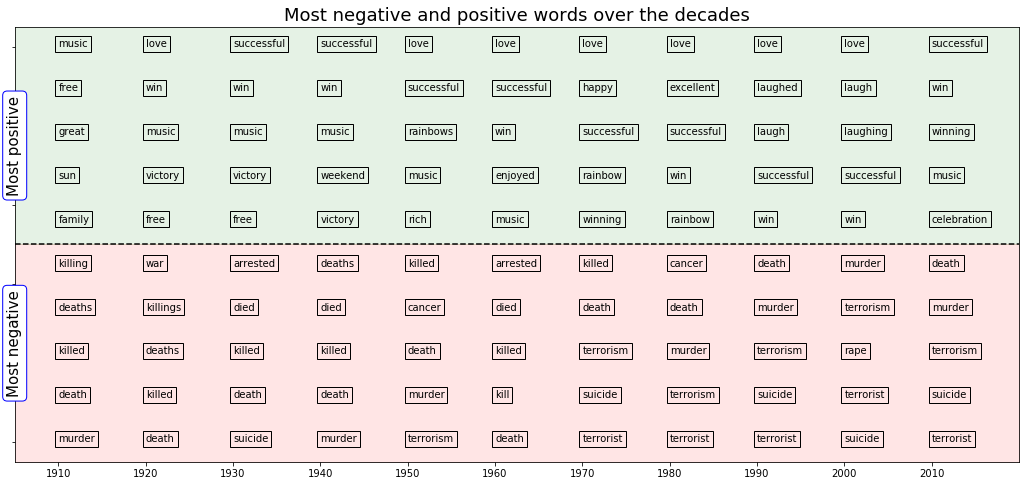

In [304]:
fig, ax = plt.subplots(figsize = (18,8))

for i in range(len(decades)):
    l = [x for x in list(zip(wiki_decades[i], map(sentiment_lookup.get, wiki_decades[i]))) if x[1] != None]
    l = list(set(l))
    l = sorted(l, key = lambda x: x[1])
    y = l[:5] + l[-5:]
    y_plot = np.linspace(0,1, num = len(y))
    for j in range(len(y)):
        ax.annotate(s = y[j][0], xy=(decades[i], y_plot[j]), bbox=dict(boxstyle="square",\
                                                                       ec="black",\
                                                                         fc="none", zorder=10.))

bbox_props = dict(boxstyle="round", fc="white", ec="b", lw=1)

ax.text(1905, 0.25, "Most negative", ha="center", va="center", rotation=90,
            size=15,
            bbox=bbox_props)

ax.text(1905, 0.75, "Most positive", ha="center", va="center", rotation=90,
            size=15,
            bbox=bbox_props)

ax.set_xlim(1905,2020)
ax.set_ylim(-.05,1.05)
ax.fill_between(x = ax.get_xlim(),y1=ax.get_ylim()[0], y2=0.5, color='red', alpha=0.1)
ax.fill_between(x = ax.get_xlim(),y1=.5, y2=1.2, color='green', alpha=0.1)
ax.hlines(y = .5, xmin=1905, xmax=2020, linestyles = '--')
ax.set_yticklabels([])
ax.set_xticks(decades)
plt.title('Most negative and positive words over the decades', fontsize = 18)
        
plt.show()

The above plot yields some interesting insights. A lot of the words like "win" and "killed" have been present since the beginning. Words like "terrorism" begins in the 1950s and more or less remains in one form or another until the 2010s. <br>

<b> A sentiment of present day </b> <br>
An important note on the sentiment is that the scores for each words was made in 'present day'. This means that the sentiment of the words were graded with respect to how people are thinking about the words today. <br>

Having had sentiment scores for each decade might have yielded very different results. One might imagine a word like "money" having a very low average happiness score if people evaluated in in the 1930s (The Great Depression).

<b> Discuss the outcome </b>

### Wordclouds

<b> What are we interested in? </b>

We are interested in identifying the words that best characterizes each decade

<b> Apply the tool </b>

In [168]:
def calculate_tf_idf(document: list, collection: list):
    # Tr calculation
    # Naive count
    tf=Counter(document)
    # other variations
    #for k in tr: tr[k] = math.log10(tr[k]+1)
    #for k in tr: tr[k] /= len(document)
    
    # IDF
    N=len(collection)
    # Flattens data
    idf = defaultdict(int)
    for d in collection:
        words = set(d)
        for x in words:
            idf[x]+=1
    
    # Calculate IDF from n and n_t
    for k in idf: idf[k] = math.log(1+ N/(idf[k]+1))
    tfidf={k:tf[k]*idf[k] for k in tf}
    
    return tfidf

def tokenize(text:str, remove_stop_words=True)-> list:
    tokenized = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokenized = [x for x in tokenized if x not in stop_words]
    return tokenized



For each of the decades, we calculate the TF-IDF of each token.

In [169]:
decades = np.arange(1910, 2020, 10)
print(decades)

[1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010]


In [170]:
decades_tf_idf = {}
for i, year in enumerate(decades):
    decades_tf_idf[year] = calculate_tf_idf(wiki_decades[i], wiki_decades)

We define a function to plot the decade from tf_idf

In [171]:
def plot_decade_from_tfidf(year:int, tfidf:dict, top_x_words=100):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")
    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

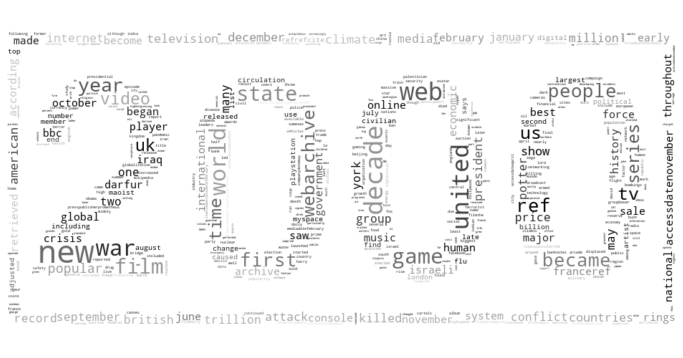

In [172]:
plot_decade_from_tfidf(decades[-2], decades_tf_idf, top_x_words=500)

<b> Discuss the outcome </b>

### WIKIPEDIA YEAR LOOKUP

The second part of the dataset is a lookup of an the year/decades wikipedia page to see if the findings from our analysis corresponds to the sentiment found on the pages. The purpose and hypotesis of this is that we will find a direct correlation between the sentiment of movies and the sorrunding decands data.

One assumption here is that will let the production of hollywood reflect the general state of the world. The reason for this is that there is no pattern wikipedia pattern for year/decade lookup only for the us. Scraping multiple sites will take too much time and loose focus of the important stuff. A reason why this assumption might be allright is due to the fact that the earlies movies in the dataset start around 1970's, which means that society is quite globalised already

**Cleaning and preprocessing**
The data is fetched through the api and is parsed using regex to a raw but filtered state

The filtering applied is:
* Removing links an references to other pages identified by being within <> or {}
* Removing links identified by starting with url=
* Removing non alpha numeric charaters
* Removing links identified by starting with http

This leaves us some partly filtered data still containing stopwords etc. ready for analysis